## **Imports**

Niyaz gave me example code for circle fitting.  Much of this might still be based off of that code once I have made the changes to fit my purposes.

In [1]:
import numpy as np
import math 
import os

# Matplotlib imports
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Circle

# Import the formatting_v3 code
from helpers.formatting_v3 import *

plot_settings = {
    'fontsize': 15,
    'tick_width': 3,
    'tick_length': 10,
    'tick_pad': 6,
    'labelpad': 5,
    'title_fontsize': 16,
    'title_pad': 10,
    'line_color': 'royalblue',
    'face_color': 'aliceblue',
    'shading': 'nearest',
    'color_map': 'RdYlBu_r',
    'line_width': 2,
    'marker_size': 15,
    'x_locator': MaxNLocator(nbins=6),
    'y_locator': MaxNLocator(nbins=6, integer=True),
}

# Import example implementation for a circle-fit. Here we use the
# circle-fit of the qkit measurement framework available at
# https://github.com/qkitgroup/qkit. We import a local copy of the file
# qkit/qkit/analysis/circle_fit/circle_fit_2019/circuit.py at the
# commit 45d6ae9.
#
# We emphasize that any fitting procedure, which can extract the
# total line width, normalize the data to the measured off-resonant
# response and extract the center-point or (complex) radius of the
# normalized circle can be used here instead.

from helpers.qkit_circuit import notch_port as circle_fit

## **Load Data**

In [2]:
# Import data via the load experiment function
filename = 'data/2025-07-31/2025-07-31_Resonator_Power_309mK'
results = load_experiment_data(filename)

# Extract the results
meta  = results["metadata"]
step  = results["step"]
sweep = results["sweep"]
data  = results["data"]

# Split the data into components 
circle_rs = reshape_circle_data(data[:,6], data[:,4], data[:,5], data[:,3])

# Get the sweep header and type
sw_header = results["sweep_headers"]
sw_type = sw_header[0].lower() if sw_header else 'unknown'

# Saving figure (circle fit name formatting)
save_path = create_save_path(filename + '_CF', fig_type='jpg')

# Format the circle plotting data
format_circle = format_circle_data(data[:,6], data[:,4], data[:,5], data[:,3],
                                   remove_phase_slope=True,
                                   reconstruct_complex=True)

## **Plotting: Raw**

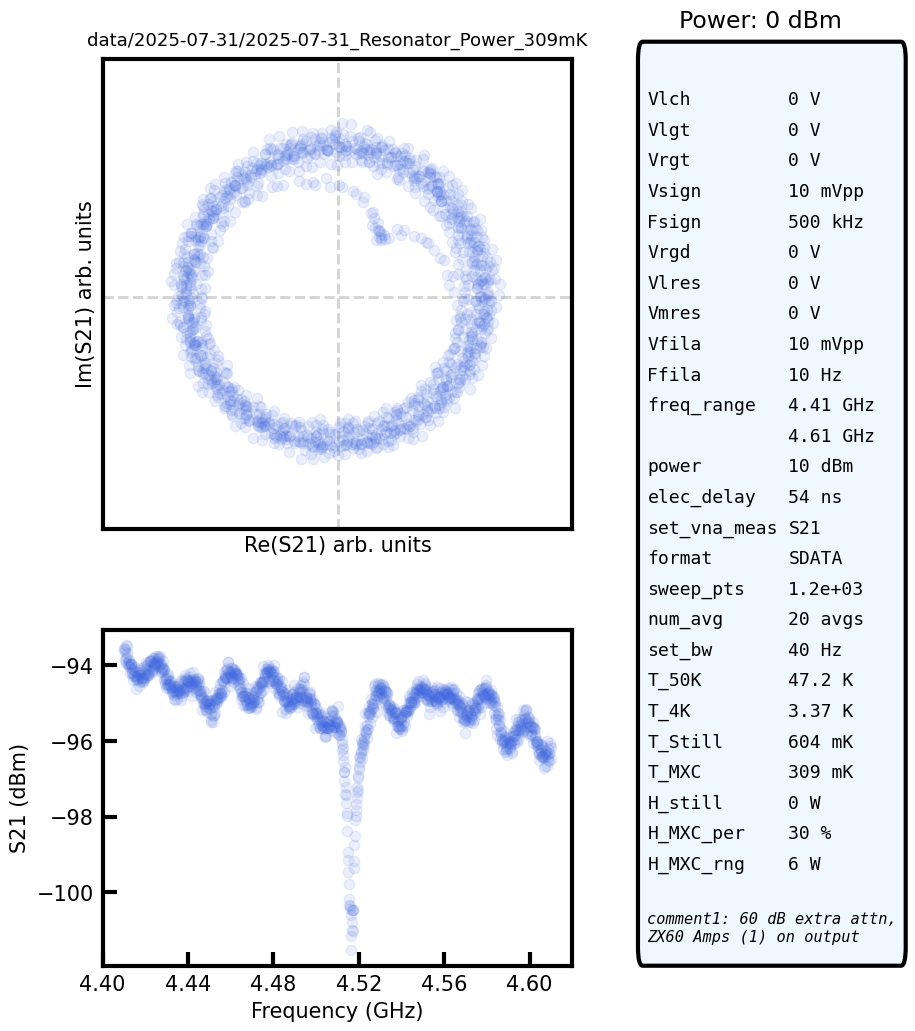

In [33]:
power =  0

# Plot Data
fig, (ax_iq, ax_res), ax_meta = triad_plot(circle_rs[power]['freq'],
                                           circle_rs[power]['S21'],
                                           plot_settings,
                                           filename=filename,
                                           h_ratio=[1.5,1],
                                           alpha=0.1)

# Metadata Table
meta_table(ax_meta, meta, fontsize=13, title = f'Power: {power} dBm', comm_on=True)

# Add tight_layout to the figure
#fig.tight_layout(pad=2)

# Save the figure
#fig.savefig(save_path, dpi=400, bbox_inches='tight')

## **Plotting: Processed**

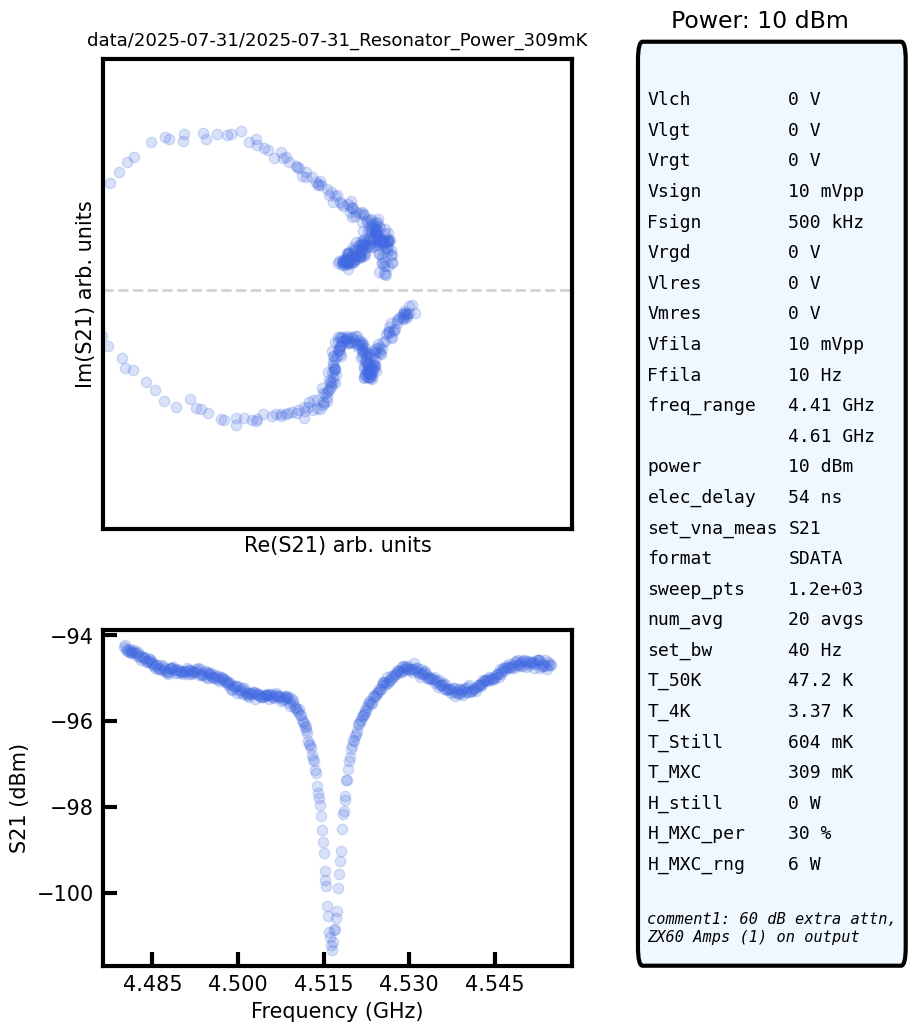

In [ ]:
power =  10

phi    = format_circle['phase'][power]* 180 / np.pi
phi_p  = format_circle['phase_prime'][power]* 180 / np.pi
f      = format_circle['freq']
complx = format_circle['real_prime'][power] + 1j * format_circle['imag_prime'][power]

# Plot Data
fig, (ax_iq, ax_res), ax_meta = triad_plot(f[420:870],
                                           complx[420:870],
                                           plot_settings,
                                           filename=filename,
                                           h_ratio=[1.5,1],
                                           alpha=0.2)

# Metadata Table
meta_table(ax_meta, meta, fontsize=13, title = f'Power: {power} dBm', comm_on=True)

# Save the figure
#fig.savefig(save_path, dpi=400, bbox_inches='tight')

## **Circle Fit**

In [5]:
# "Use 15 dB isolation of the background path as example
# (this is the default value)." - qkit documentation

power =  10

phi    = format_circle['phase'][power]* 180 / np.pi
phi_p  = format_circle['phase_prime'][power]* 180 / np.pi
f      = format_circle['freq']
complx = format_circle['real_prime'][power] + 1j * format_circle['imag_prime'][power]

# Set data bounds for fit/plot
indx_b = 580    # Bottom index
indx_t = 700    # Top index

# Perform the circle fit
cf = circle_fit(f[indx_b:indx_t], complx[indx_b:indx_t])
cf.autofit(isolation=15)

# Print general fit results
print("f_res (GHz):     {:.4f}".format(cf.fitresults["fr"]/1e9))
print("Q_cf:            {:.0f}".format(cf.fitresults["Ql"]))
print("Qi_cf:           {:.0f}".format(cf.fitresults["Qi"]))
print("Qc_cf:           {:.0f}".format(cf.fitresults["Qc"]))
print("kappa/2pi (MHz): {:.3f}".format(cf.fitresults["fr"]/cf.fitresults["Ql"]/1e6))

f_res (GHz):     4.5166
Q_cf:            755
Qi_cf:           1561
Qc_cf:           1462
kappa/2pi (MHz): 5.983


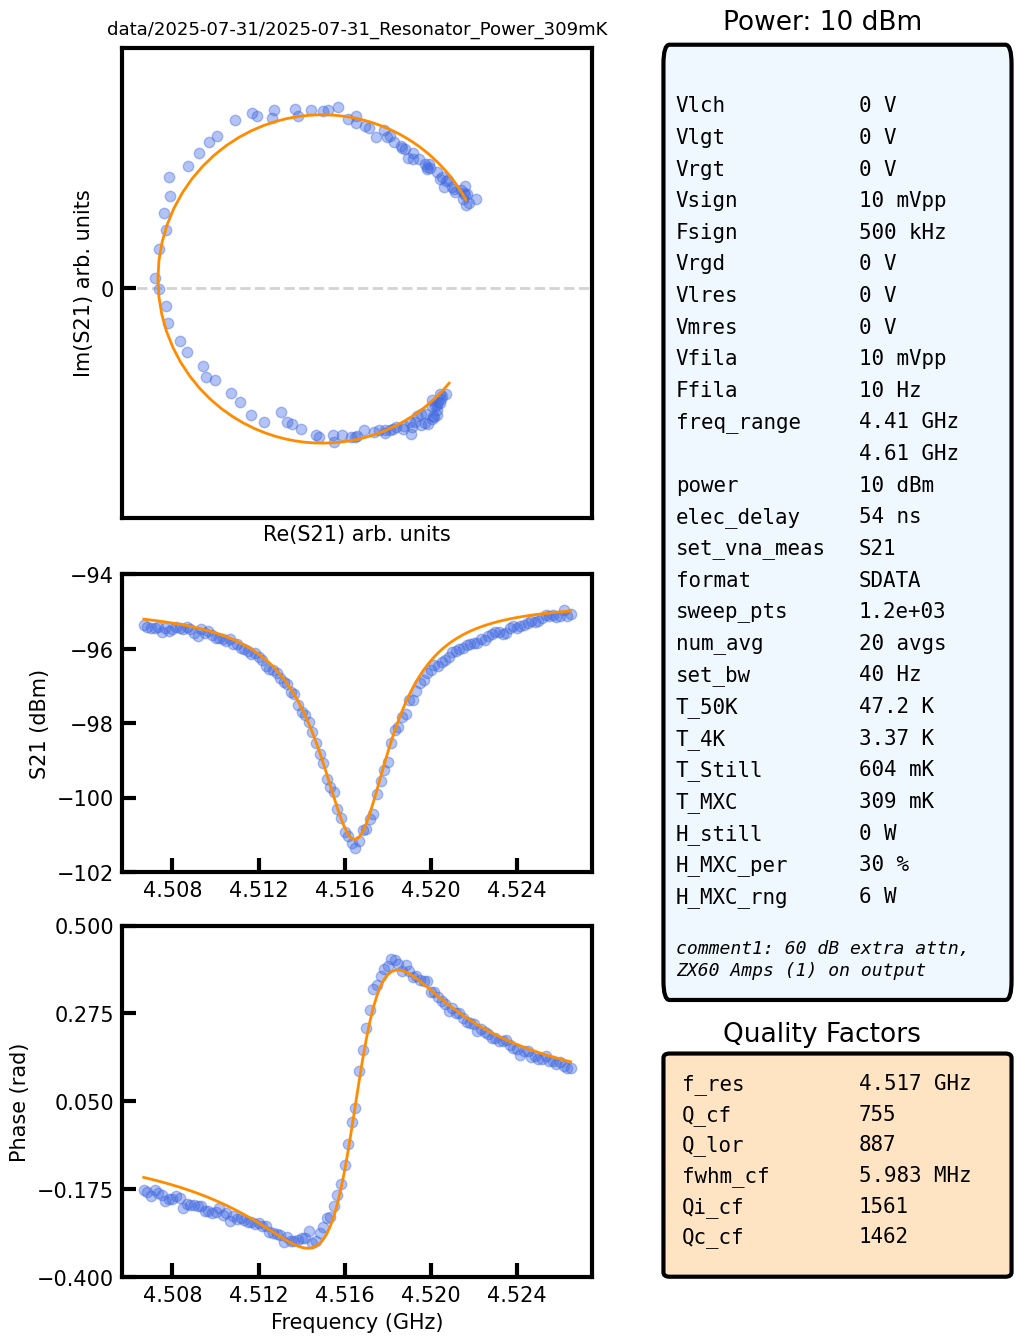

In [7]:
# Plot Data
fig, (ax_iq, ax_res, ax_phase), ax_meta, ax_qfact, qdat = circle_plot(
                                f[indx_b:indx_t],
                                complx[indx_b:indx_t],
                                plot_settings,
                                filename=filename,
                                h_ratio = [1.6, 1, 0.25, 0.75],
                                alpha=0.4,
                                c_adj=[0,0],
                                cf=cf,
                                scale=1/55000,
                                fit_color='darkorange')

# Metadata Table
meta_table(ax_meta, meta, fontsize=15, title = f'Power: {power} dBm', comm_on=True)
# Quality Factor Table
qfactor_table(ax_qfact, qdat, fontsize=15, title="Quality Factors")

# Save the figure
#fig.savefig(save_path, dpi=400, bbox_inches='tight')

## **Plotting: Diagnostic**

In [73]:
# Data Formatting for Fitting Plots
scale    = 55000

f_vals = f[indx_b:indx_t] * 1e-9
mags   = np.abs(complx[indx_b:indx_t])
phas   = phi_p[indx_b:indx_t]
popt   = fit_data(f_vals, mags, fit_type='lorz_inv')[0]
qlor   = popt[1]/popt[2]

mlog   = 20*np.log10(mags)
lorz   = 20*np.log10(lorz_inv(f_vals, *popt))
cfit   = 20*np.log10(cf.z_data_sim_norm/scale)
cang   = np.angle(cf.z_data_sim_norm)*180/np.pi

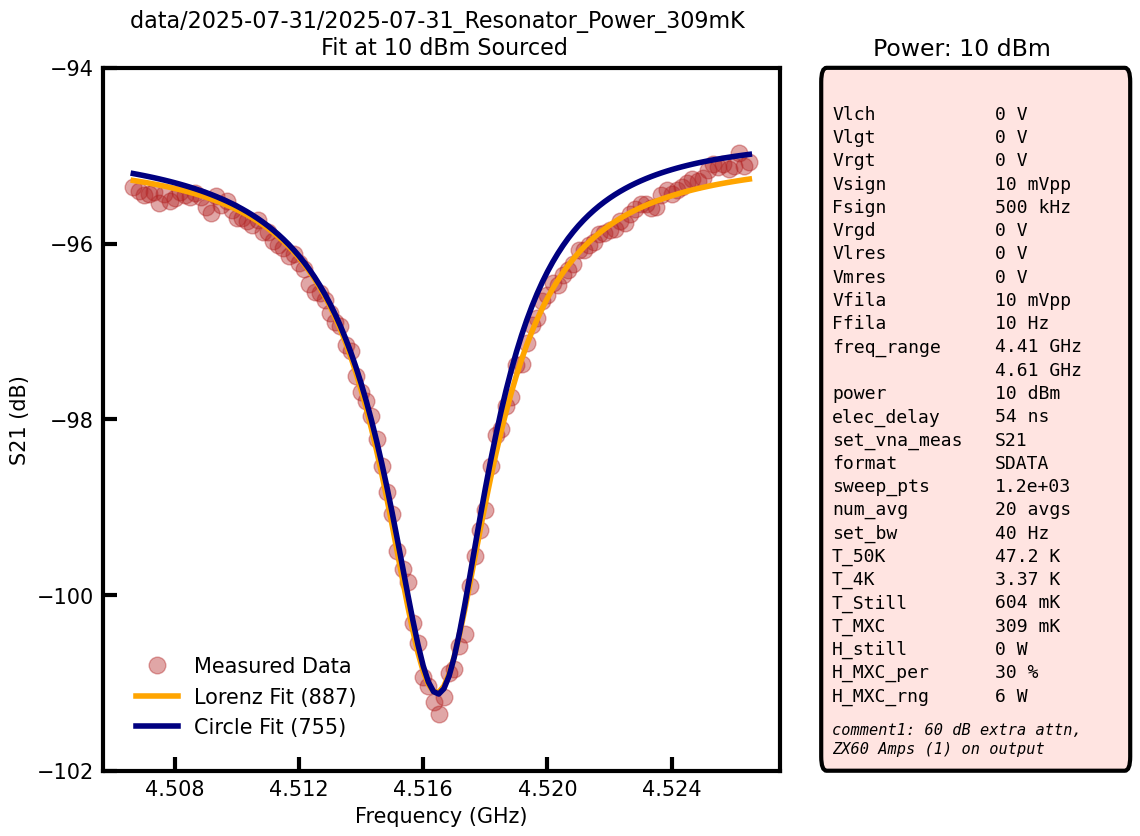

In [74]:
# Create Figure
fig, ax_plot, ax_meta = format_plot()

# Plot the Linecut
plot_linecut(ax_plot, f_vals, mlog, xlabel="Frequency (GHz)", ylabel="S21 (dB)", 
             filename=filename + f" \n Fit at {power} dBm Sourced", style=plot_settings,
             color='firebrick', marker='o', linewidth=0, markersize=12, alpha=0.4,
             label='Measured Data')

ax_plot.plot(f_vals, lorz, color='orange', linewidth=4, 
             label=f'Lorenz Fit ({qlor:.0f})')
ax_plot.plot(f_vals, cfit, color='navy', linewidth=4, 
             label=f'Circle Fit ({cf.fitresults["Ql"]:.0f})')
ax_plot.legend(fontsize=15, frameon=False, borderaxespad=1.2)

# Metadata Table
meta_table(ax_meta, meta, fontsize=13, title = f'Power: {power} dBm', comm_on=True,
           facecolor='mistyrose')

# Add tight_layout to the figure
fig.tight_layout(pad=3.0)

# Save the figure
#fig.savefig(save_path, dpi=400, bbox_inches='tight')


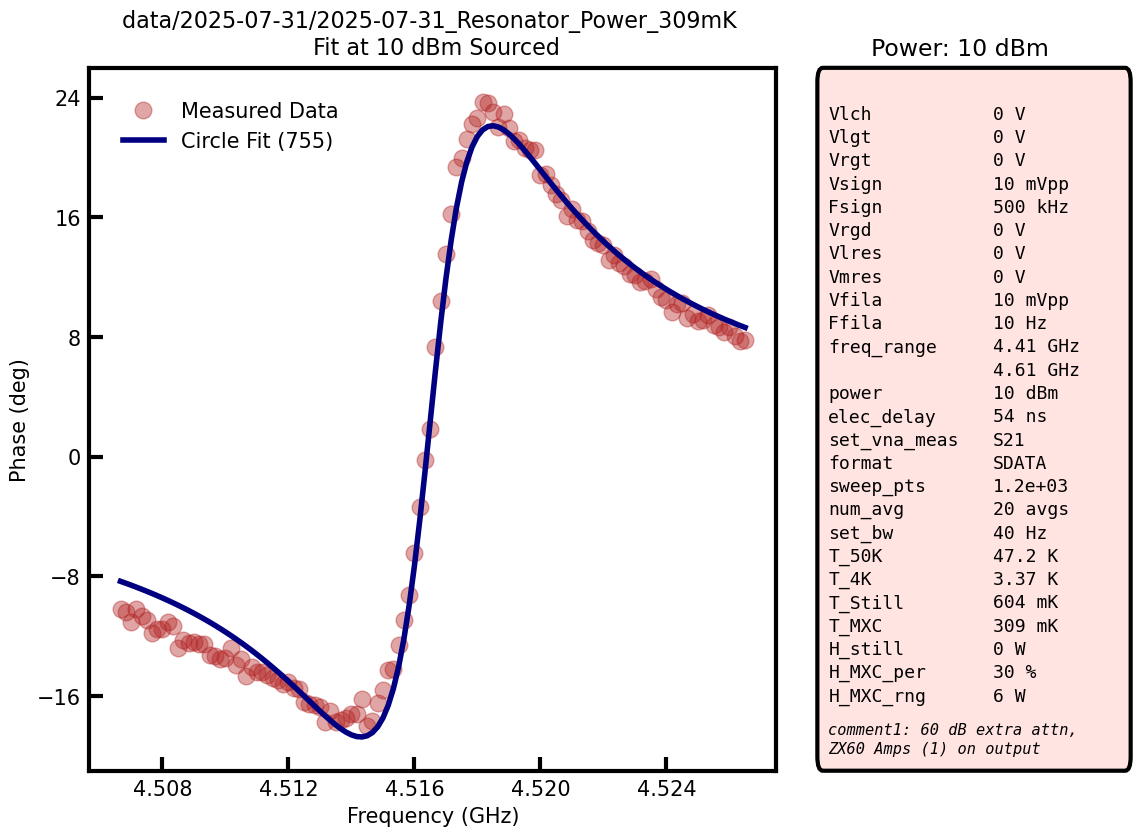

In [75]:
# Create Figure
fig, ax_plot, ax_meta = format_plot()

# Plot the Linecut
plot_linecut(ax_plot, f_vals, phas, xlabel="Frequency (GHz)", ylabel="Phase (deg)", 
             filename=filename + f" \n Fit at {power} dBm Sourced", style=plot_settings,
             color='firebrick', marker='o', linewidth=0, markersize=12, alpha=0.4,
             label='Measured Data')

ax_plot.plot(f_vals, cang, color='navy', linewidth=4, 
             label=f'Circle Fit ({cf.fitresults["Ql"]:.0f})')

ax_plot.legend(fontsize=15, frameon=False, borderaxespad=1.2)

# Metadata Table
meta_table(ax_meta, meta, fontsize=13, title = f'Power: {power} dBm', comm_on=True,
           facecolor='mistyrose')

# Add tight_layout to the figure
fig.tight_layout(pad=3.0)

# Save the figure
#fig.savefig(save_path, dpi=400, bbox_inches='tight')